todo: remove my local path with sonyabudilova from all the prints

In [3]:
import os, json
import xml.etree.ElementTree as ET
from collections import Counter
import matplotlib.pyplot as plt
from pathlib import Path
from utilities import remove_duplicates, get_all_elements

In [4]:
# inside there are folders
with open('models_locations.json') as f:
    models_relative_locations = json.load(f)

In [5]:
len(models_relative_locations)

18

In [ ]:
# Structure of Dataset-of-Gazebo-Worlds-Models-and-Maps differs, that is why separate file is needed to load filepaths
with open('dataset_worlds_models_dict.json') as f:
    dataset_worlds_models_dict = json.load(f)

There are 18 projects with separate chunks of models.

In [ ]:
dataset_models_folders = [item for sublist in dataset_worlds_models_dict.values() for item in (sublist if isinstance(sublist, list) else [sublist])]
dataset_models_folders = ["/Dataset-of-Gazebo-Worlds-Models-and-Maps/worlds/" + x for x in dataset_models_folders]

In [19]:
models_relative_locations += dataset_models_folders

In [21]:
def find_sdf_files(folders):
    sdf_files = {}
    
    for folder in folders:
        path = Path(os.getcwd() + folder)
        for file in path.rglob("*.sdf"):
            if folder not in sdf_files.keys():
                sdf_files[folder] = []
            sdf_files[folder].append(file)

        if folder not in sdf_files.keys():
            print(folder)
    
    return sdf_files

sdf_files = find_sdf_files(models_relative_locations)

sorted_files_dict = sorted(sdf_files.items(), key=lambda item: len(item[1]))
print(f'Total number of files: {sum([len(x) for x in sdf_files.values()])}')
for chunk in sorted_files_dict:
    print(f"{chunk[0]} - {len(chunk[1])}")


Total number of files: 1971
/cpr_gazebo/cpr_inspection_gazebo/models - 1
/fetch_gazebo/fetch_gazebo/models - 2
/ARTI-Robots_gazebo_worlds/gazebo_worlds/models - 4
/Dataset-of-Gazebo-Worlds-Models-and-Maps/robots - 7
/ardupilot_gazebo/models - 11
/aws-robomaker-small-warehouse-world/models - 14
/Dataset-of-Gazebo-Worlds-Models-and-Maps/worlds/experiment_rooms/models - 14
/aws-robomaker-racetrack-world/models - 20
/Dataset-of-Gazebo-Worlds-Models-and-Maps/worlds/office/office_part1/models - 20
/Dataset-of-Gazebo-Worlds-Models-and-Maps/worlds/hospital/models_part1 - 21
/Dataset-of-Gazebo-Worlds-Models-and-Maps/worlds/hospital/models_part2 - 25
/Dataset-of-Gazebo-Worlds-Models-and-Maps/worlds/hospital/models_part3 - 25
/Dataset-of-Gazebo-Worlds-Models-and-Maps/worlds/hospital/models_part4 - 30
/PX4-gazebo-models/models - 31
/aws-robomaker-bookstore-world/models - 34
/rotors_simulator/rotors_gazebo/models - 35
/fetch_gazebo/fetchit_challenge/models - 37
/aws-robomaker-hospital-world/models 

In [22]:
all_models_files = [file for files in sdf_files.values() for file in files]

In [23]:
unique_files = remove_duplicates([str(x) for x in all_models_files])

print(f"All models files: {len(all_models_files)}")
print(f"Models files without duplicates: {len(unique_files)}")

All models files: 1971
Models files without duplicates: 1062


In [24]:
# recursively find models, includes, plugins
# find static (not recursively)
# find joints (and look how many are direct and if there are recursive also)
# search for sensors also

# actors? no
# analyse links? ask chapgt

In [25]:
def find_elements_by_tag_with_depth(element, target_tag, depth=0, results=None):
    if results is None:
        results = []
    
    if element.tag == target_tag:
        results.append((element, depth))

    for child in element:
        find_elements_by_tag_with_depth(child, target_tag, depth + 1, results)
    
    return results

def get_all_elements(target_tag: str, file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    return find_elements_by_tag_with_depth(root, target_tag)

In [26]:
models_dict = {}
for model_file_path in unique_files:
    res = get_all_elements("model", model_file_path)
    # first element is <model>, however, the goal is to count nested models, not the root one
    nested_models = list(filter(lambda x: x[1] != 1, res))
    models_dict[model_file_path] = nested_models
models_dict = {k: v for k, v in models_dict.items() if v != []}

In [27]:
list(map(lambda x: (x[0].split("/")[-2], len(x[1])), models_dict.items()))

[('office_small', 7),
 ('iris_hitl', 1),
 ('iris_triple_depth_camera', 3),
 ('exp_empty_rooms', 4),
 ('conveyor_belt_tall_ariac', 2),
 ('conveyor_belt_ariac', 2)]

Only 6 models have nested models created with model element, these models are complex, e.g., office is a whole building.

In [28]:
includes_dict = {}
for model_file_path in unique_files:
    res = get_all_elements("include", model_file_path)
    for elem, depth in res:
        if not elem.find("uri").text.startswith("model://"):
            print(f"include element is not a model, uri of include element = {elem.find('uri').text}, file = {model_file_path}")
    includes_dict[model_file_path] = res

include element is not a model, uri of include element = x500, file = /Users/sonyabudilova/Documents/NaUKMA/4_year/диплом/gazebo_worlds_analysis/PX4-gazebo-models/models/x500_lidar_front/model.sdf
include element is not a model, uri of include element = x500, file = /Users/sonyabudilova/Documents/NaUKMA/4_year/диплом/gazebo_worlds_analysis/PX4-gazebo-models/models/x500_mono_cam_down/model.sdf
include element is not a model, uri of include element = x500, file = /Users/sonyabudilova/Documents/NaUKMA/4_year/диплом/gazebo_worlds_analysis/PX4-gazebo-models/models/x500_lidar_down/model.sdf
include element is not a model, uri of include element = x500, file = /Users/sonyabudilova/Documents/NaUKMA/4_year/диплом/gazebo_worlds_analysis/PX4-gazebo-models/models/x500_vision/model.sdf
include element is not a model, uri of include element = x500, file = /Users/sonyabudilova/Documents/NaUKMA/4_year/диплом/gazebo_worlds_analysis/PX4-gazebo-models/models/x500_lidar_2d/model.sdf
include element is not

\<include\> elements start with "model://" but there are 9 models where this pattern was not met, even though include contains models there as well.

In [31]:
list(filter(lambda x: x[1] != 2, [y for x in includes_dict.values() for y in x]))

[(<Element 'include' at 0x1129c0630>, 1)]

All the includes are direct children of model element, except for one model

In [32]:
list(filter(lambda x: any(filter(lambda y: y[1] != 2, x[1])), includes_dict.items()))

[('/Users/sonyabudilova/Documents/NaUKMA/4_year/диплом/gazebo_worlds_analysis/PX4-gazebo-models/models/spacecraft_2d/model.sdf',
  [(<Element 'include' at 0x1129c0630>, 1)])]

PX4-gazebo-models/models/spacecraft_2d/model.sdf has no model element, instead it has include element with Gazebo Fuel model HTTPS link inside

In [33]:
includes_amounts = [len(v) for v in includes_dict.values()]
includes_amounts_counts = Counter(includes_amounts).items()

In [34]:
includes_amounts_counts = sorted(includes_amounts_counts, key=lambda x: x[0])

In [35]:
includes_amounts_counts

[(0, 1006), (1, 19), (2, 26), (3, 4), (4, 2), (6, 1), (10, 3), (28, 1)]

In [36]:
includes_amounts_counts[0][1] / len(unique_files)

0.9472693032015066

94% of files have no includes

todo: how many files have no nested models and no includes?

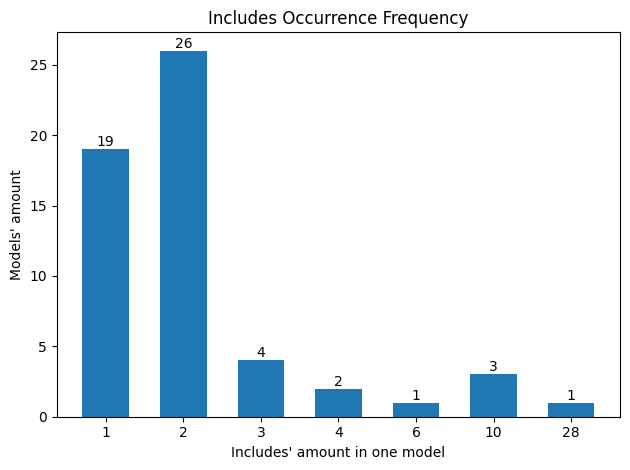

In [37]:
xs = [x[0] for x in includes_amounts_counts[1:]] # without first element since it is the biggest
ys = [x[1] for x in includes_amounts_counts[1:]]

positions = range(len(xs))

bars = plt.bar(positions, ys, width=0.6)
plt.bar_label(bars)
plt.xticks(positions, xs)
plt.xlabel("Includes' amount in one model")
plt.ylabel("Models' amount")
plt.title("Includes Occurrence Frequency")
plt.tight_layout()
plt.show()


In [38]:
models_and_includes_dict = {}
for model_file_path in unique_files:
    all_model_elements = get_all_elements("model", model_file_path)
    # first element is <model>, however, the goal is to count nested models, not the root one
    nested_models = list(filter(lambda x: x[1] != 1, all_model_elements))
    models_and_includes_dict[model_file_path] = nested_models
    all_include_elements = get_all_elements("include", model_file_path)
    models_and_includes_dict[model_file_path] += all_include_elements

# remove model files that have no nested models and includes
has_models_or_includes = [(k, v) for k, v in models_and_includes_dict.items() if v != []]
no_models_and_includes = [(k, v) for k, v in models_and_includes_dict.items() if v == []]

In [39]:
len(has_models_or_includes)

61

In [40]:
len(no_models_and_includes)

1001

In [41]:
len(models_and_includes_dict)

1062

In [42]:
for key, value in has_models_or_includes:
    has_model = any(filter(lambda x: x[0].tag == "model", value))
    has_include = any(filter(lambda x: x[0].tag == "include", value))
    if has_model and has_include:
        print(f"Model with nested models and includes = {key}")
        print(f"Amount of models and includes = {len(value)}")

Model with nested models and includes = /Users/sonyabudilova/Documents/NaUKMA/4_year/диплом/gazebo_worlds_analysis/PX4-SITL_gazebo-classic/models/iris_triple_depth_camera/iris_triple_depth_camera.sdf
Amount of models and includes = 5


In [43]:
plugins_dict = {}
for model_file_path in unique_files:
    plugins_dict[model_file_path] = get_all_elements("plugin", model_file_path)

In [44]:
plugins_amounts = [len(v) for v in plugins_dict.values()]
plugins_amounts_counts = Counter(plugins_amounts).items()
plugins_amounts_counts = sorted(plugins_amounts_counts, key=lambda x: x[0])

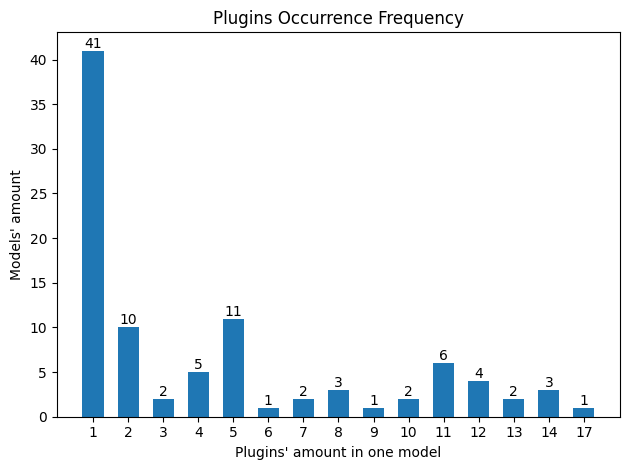

In [45]:
xs = [x[0] for x in plugins_amounts_counts[1:]] # without first element since it is the biggest
ys = [x[1] for x in plugins_amounts_counts[1:]]

positions = range(len(xs))

bars = plt.bar(positions, ys, width=0.6)
plt.bar_label(bars)
plt.xticks(positions, xs)
plt.xlabel("Plugins' amount in one model")
plt.ylabel("Models' amount")
plt.title("Plugins Occurrence Frequency")
plt.tight_layout()
plt.show()

In [46]:
all_plugins = [(y[0].attrib["name"], y[0].attrib["filename"]) for x in plugins_dict.values() for y in x]

In [47]:
plugins_counts = Counter(all_plugins).items()

In [48]:
plugins_short_list = sorted(list(filter(lambda x: x[1] > 3, plugins_counts)), key=lambda x: x[1])

In [49]:
def find_duplicates(input_list):
    count = Counter(input_list)
    duplicates = [item for item, freq in count.items() if freq > 1]
    return duplicates

def process_tuples(input_list):
    duplicates = find_duplicates(map(lambda x: x[1], input_list))
    result = []
    
    for first, second in input_list:
        if second in duplicates:
            result.append(f"{first}, {second}")
        else:
            result.append(second)

    return result

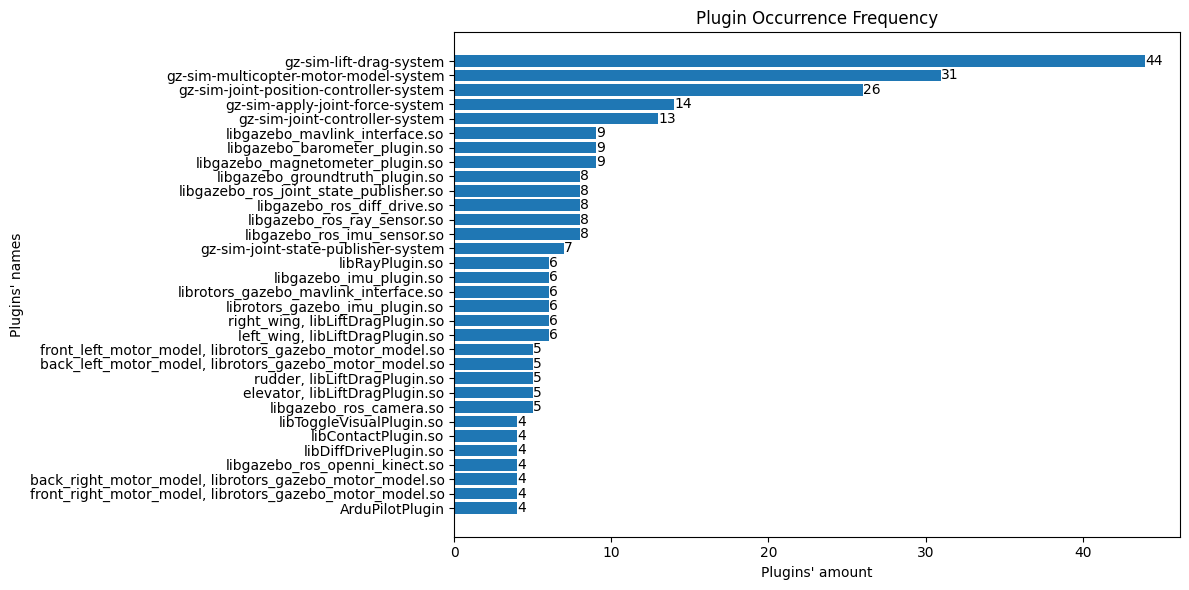

In [50]:
keys = process_tuples([x[0] for x in plugins_short_list])
values = [x[1] for x in plugins_short_list]

plt.figure(figsize=(12, 6))
bars = plt.barh(keys, values)
plt.bar_label(bars)
plt.xlabel("Plugins' amount")
plt.ylabel("Plugins' names")
plt.title("Plugin Occurrence Frequency")
plt.tight_layout()
plt.show()
# plugins that occured only less than 4 times were not included in the plot

there are two mavlink interfaces, and librotos_gazebo_motor_model is repeated, and libLiftDragPlugin is repeated

In [51]:
static_dict = {}
for model_file_path in unique_files:
    res = get_all_elements("static", model_file_path)
    static_dict[model_file_path] = res

In [53]:
static = list(filter(lambda x: len(x[1]) > 0, static_dict.items()))
print(len(static))
print(len(static) / len(all_models_files))

819
0.4155251141552511


41% of all models are static

In [54]:
joints_dict = {}
for model_file_path in unique_files:
    res = get_all_elements("joint", model_file_path)
    joints_dict[model_file_path] = res

In [55]:
joints_amounts = list(map(lambda x: len(x), joints_dict.values()))
joints_amounts_counts = Counter(joints_amounts)
joints_amounts_counts = sorted(joints_amounts_counts.items(), key=lambda x: x[0])

In [56]:
print(joints_amounts_counts[0])
print(joints_amounts_counts[0][1] / len(all_models_files))

(0, 947)
0.480466768138001


48% of models does not contain any joints

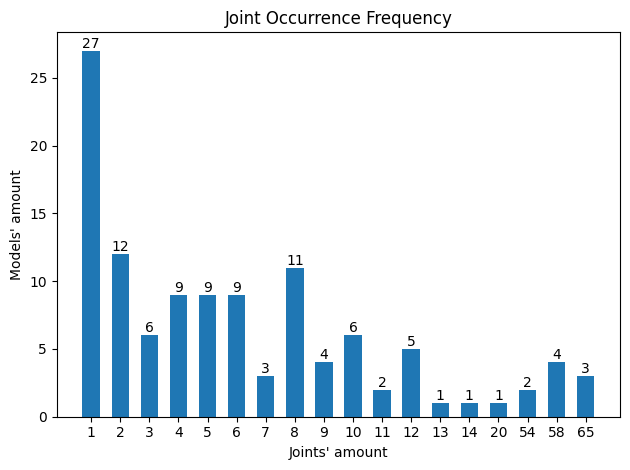

In [57]:
xs = [x[0] for x in joints_amounts_counts[1:]]
ys = [x[1] for x in joints_amounts_counts[1:]]

positions = range(len(xs))

bars = plt.bar(positions, ys, width=0.6)
plt.bar_label(bars)
plt.xticks(positions, xs)
plt.xlabel("Joints' amount")
plt.ylabel("Models' amount")
plt.title("Joint Occurrence Frequency")
plt.tight_layout()
plt.show()


In [58]:
sensors_dict = {}
for model_file_path in unique_files:
    res = get_all_elements("sensor", model_file_path)
    sensors_dict[model_file_path] = res

In [59]:
sensor_amounts = [len(x) for x in sensors_dict.values()]
sensor_amounts_counts = Counter(sensor_amounts)
sensor_amounts_counts = sorted(sensor_amounts_counts.items(), key=lambda x: x[0])

In [60]:
sensor_amounts_counts

[(0, 984), (1, 42), (2, 10), (3, 8), (4, 13), (5, 1), (18, 4)]

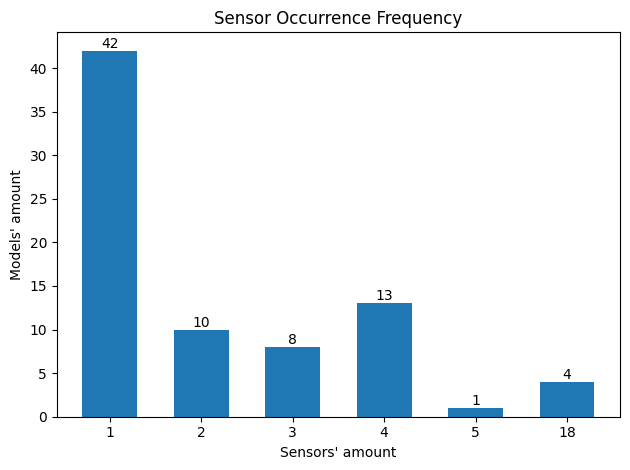

In [61]:
xs = [x[0] for x in sensor_amounts_counts[1:]]
ys = [x[1] for x in sensor_amounts_counts[1:]]

positions = range(len(xs))

bars = plt.bar(positions, ys, width=0.6)
plt.bar_label(bars)
plt.xticks(positions, xs)
plt.xlabel("Sensors' amount")
plt.ylabel("Models' amount")
plt.title("Sensor Occurrence Frequency")
plt.tight_layout()
plt.show()


In [62]:
sensor_amounts_counts[0][1] / len(unique_files)

0.9265536723163842

92% of all models do not have sensors

In [63]:
all_sensors = [y for x in sensors_dict.values() for y in x]

In [64]:
sensor_types = {}
for sensor, depth in all_sensors:
    key = (sensor.attrib["name"], sensor.attrib["type"])
    if key not in sensor_types.keys():
        sensor_types[key] = 0
    sensor_types[key] += 1

In [65]:
len(sensor_types)

62

In [66]:
more_than_one = list(filter(lambda x: x[1] > 1, sorted(sensor_types.items(), key=lambda x: x[1])))
len(more_than_one)

38

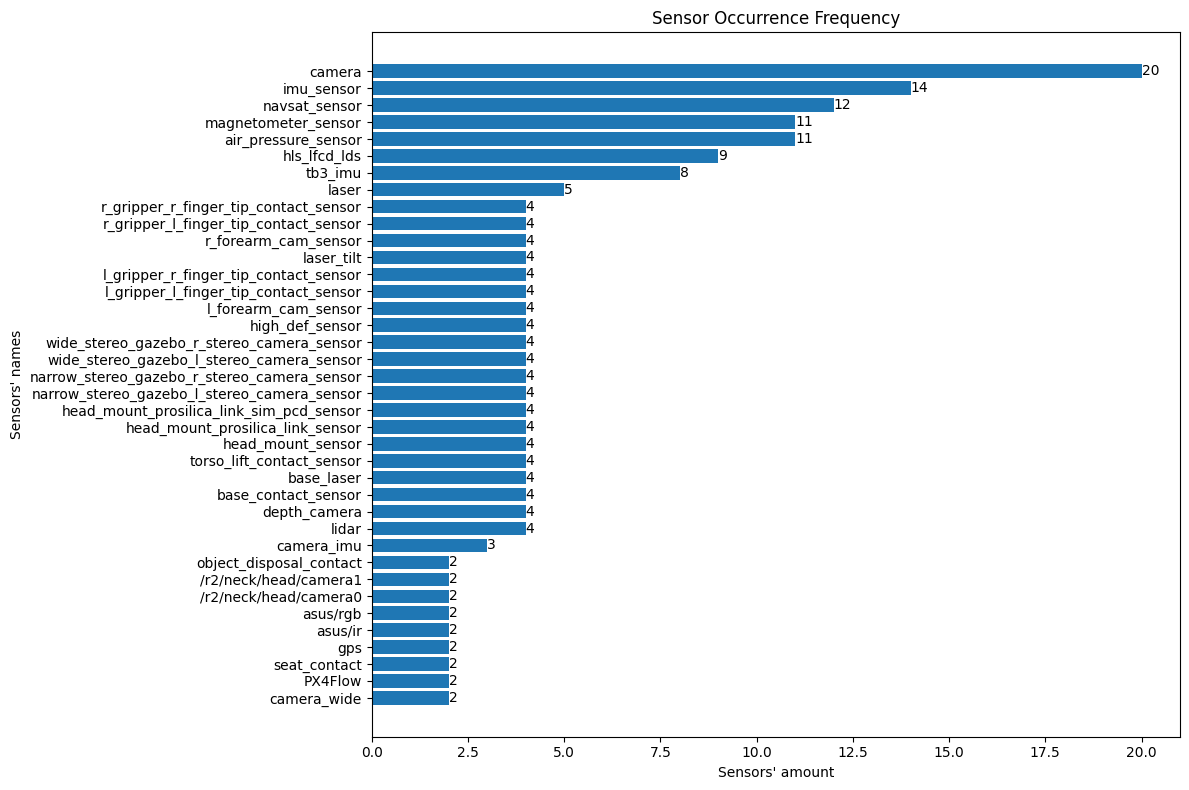

In [67]:
keys = [x[0][0] for x in more_than_one]
values = [x[1] for x in more_than_one]

plt.figure(figsize=(12, 8))
bars = plt.barh(keys, values)
plt.bar_label(bars)
plt.xlabel("Sensors' amount")
plt.ylabel("Sensors' names")
plt.title("Sensor Occurrence Frequency")
plt.tight_layout()
plt.show()
# sensors that occured only once were not included in the plot